In [1]:
import tensorflow as tf
import torch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import pandas as pd
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
import pickle
import os
import re

from konlpy.tag import Okt

Using TensorFlow backend.


In [2]:
data = pd.read_csv("ratings_test.txt", sep='\t')
data = data[:3000]

In [3]:
train = data[:1000]
validation = data[1000:2000]
test = data[2000:]

print(train.shape)
print(validation.shape)
print(test.shape)


(1000, 3)
(1000, 3)
(1000, 3)


In [4]:
sentences = data['document']
print(sentences.shape)
label = data['label']
print(label.shape)

(3000,)
(3000,)


In [5]:
# 태그 단어
PAD = "<PADDING>"   # 패딩
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
OOV_INDEX = 1


# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 임베딩 벡터 차원
embedding_dim = 100

# LSTM 히든레이어 차원
lstm_hidden_dim = 128

# 정규 표현식 필터
RE_FILTER = re.compile("[.,!?\"':;~()‘/_<>]")

In [6]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Okt()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 모든 문장 반복
    for sentence in sentences:
        # 특수기호 제거
        sentence = re.sub(RE_FILTER, "", sentence)
        
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(tagger.morphs(sentence))
        sentences_pos.append(sentence)
        
    return sentences_pos

In [7]:
sentences = pos_tag(sentences)
x_tr = pos_tag(train['document'])
x_v = pos_tag(validation['document'])
x_te = pos_tag(test['document'])

y_tr = label[:1000]
y_v  = label[1000:2000]
y_te = label[2000:3000]
for i in range(10):
  print(sentences[i])

굳 ㅋ
GDNTOPCLASSINTHECLUB
뭐 야 이 평점 들 은 나쁘진 않지만 10 점 짜 리 는 더 더욱 아니잖아
지루하지는 않은데 완전 막장 임 돈 주고 보기 에는
3 D 만 아니었어도 별 다섯 개 줬을텐데 왜 3 D 로 나와서 제 심기 를 불편하게 하죠
음악 이 주가 된 최고 의 음악 영화
진정한 쓰레기
마치 미국 애니 에서 튀어나온듯 한 창의력 없는 로봇 디자인 부터가 고개 를 젖게 한다
갈수록 개판 되가는 중국영화 유치하고 내용 없음 폼 잡다 끝남 말 도 안되는 무기 에 유치한 cg 남무 아 그립다 동사서독 같은 영화 가 이건 3 류 아 류작 이다
이별 의 아픔 뒤 에 찾아오는 새로운 인연 의 기쁨 But 모든 사람 이 그렇지는 않네


In [8]:
for i in range(10):
    print(x_v[i])

^^
아 남주랑 여주 외모 가 너무 밸붕 이네 집중 이 안 됌
청 하 누나 청 하 누나 를 알 게 해준 영화
봐도 봐도 잼있음
평점 이 이해 가 안되네 배우 들 연기 도 짱 연출 도 짱
와 많은 생각 을 하게 하는 영화 다 차분하게 적나라하다 본성 욕망 고뇌 차갑게 파고드는 기시감
울 아들 이 재밌어 하네 요전 별로 ㅋㅋ
이 거 진짜 하나 도 안 무서움 별 하나 주기도 아까워 ㅋ
장인 이란 끝없는 반복 에서 나온다는 교훈 을 보여준다 딱 그 교훈 까지만
부산 국제 영화제 에서 본 영화 지루하고 왜 2 편이 나왔는지 몰라 남는거 없


In [9]:
words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, OOV]

In [10]:
words

['<PADDING>',
 '<OOV>',
 '향수',
 '생각나지',
 '미의',
 '만큼이나',
 '여성성',
 '교만하고',
 '송승헌',
 '눈빛',
 '어이없었지만',
 '콘서트',
 '액션영화',
 '시키는',
 '박정민',
 '킬머형',
 '합당',
 '싶어서',
 '찾고',
 '우짜',
 '낭',
 '써라',
 '우주여행',
 '행해',
 '디카프리오',
 '그럴듯했다',
 '재미있었다면서',
 '이러냐',
 '부족한',
 '요전',
 '신선하고',
 '도식',
 '였다니',
 '인',
 '그나저나',
 '멋있게',
 '낮노',
 '낭패',
 '간결하고',
 '엄태웅',
 '사과',
 '네티즌',
 '인간',
 '다를것이',
 '유덜',
 '구태의연한',
 '실제',
 '한참',
 '수입',
 '떠오르는',
 '위노나',
 '할게',
 '어거지',
 '아저씨',
 '영화인',
 '마십시오',
 '심함',
 '안되지',
 '붙여넣기',
 '코스트',
 '휴머니즘',
 '특별한',
 '지키는',
 '노트북',
 '볼',
 '인디아나',
 '믿지말라',
 '우베',
 '넘겨야',
 '비틀',
 '크다',
 '길어',
 '인기',
 '알았는데',
 '해보자',
 '챔프',
 'Ill',
 '서도',
 '아무튼',
 '쓰리가',
 '무리면서',
 '자연스러운',
 '끝났다',
 '던져서',
 '세치',
 '연장전',
 '좋게',
 '지겨울수가',
 '좋았습니다',
 '염',
 '도도',
 '엮어',
 '느껴',
 '아닌가',
 '어울림',
 '박신혜',
 '빌어먹을',
 '발칸포',
 '악역',
 '평론',
 '없었어요',
 '설정',
 '들어오겠냐',
 '있으나',
 '정선',
 '미셔요',
 '있다는거에서',
 'ㅋㅠㅠ',
 '무용가',
 '모르는것처럼',
 '오래도',
 '학식',
 '데이트',
 '런가',
 '하디',
 '중요',
 '조직',
 '거지',
 '놀란',
 '중',
 '나오지도',
 '드래곤볼',
 '아까웠',
 '강우',
 '온통',

In [11]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

In [12]:
word_to_index

{'<PADDING>': 0,
 '<OOV>': 1,
 '향수': 2,
 '생각나지': 3,
 '미의': 4,
 '만큼이나': 5,
 '여성성': 6,
 '교만하고': 7,
 '송승헌': 8,
 '눈빛': 9,
 '어이없었지만': 10,
 '콘서트': 11,
 '액션영화': 12,
 '시키는': 13,
 '박정민': 14,
 '킬머형': 15,
 '합당': 16,
 '싶어서': 17,
 '찾고': 18,
 '우짜': 19,
 '낭': 20,
 '써라': 21,
 '우주여행': 22,
 '행해': 23,
 '디카프리오': 24,
 '그럴듯했다': 25,
 '재미있었다면서': 26,
 '이러냐': 27,
 '부족한': 28,
 '요전': 29,
 '신선하고': 30,
 '도식': 31,
 '였다니': 32,
 '인': 33,
 '그나저나': 34,
 '멋있게': 35,
 '낮노': 36,
 '낭패': 37,
 '간결하고': 38,
 '엄태웅': 39,
 '사과': 40,
 '네티즌': 41,
 '인간': 42,
 '다를것이': 43,
 '유덜': 44,
 '구태의연한': 45,
 '실제': 46,
 '한참': 47,
 '수입': 48,
 '떠오르는': 49,
 '위노나': 50,
 '할게': 51,
 '어거지': 52,
 '아저씨': 53,
 '영화인': 54,
 '마십시오': 55,
 '심함': 56,
 '안되지': 57,
 '붙여넣기': 58,
 '코스트': 59,
 '휴머니즘': 60,
 '특별한': 61,
 '지키는': 62,
 '노트북': 63,
 '볼': 64,
 '인디아나': 65,
 '믿지말라': 66,
 '우베': 67,
 '넘겨야': 68,
 '비틀': 69,
 '크다': 70,
 '길어': 71,
 '인기': 72,
 '알았는데': 73,
 '해보자': 74,
 '챔프': 75,
 'Ill': 76,
 '서도': 77,
 '아무튼': 78,
 '쓰리가': 79,
 '무리면서': 80,
 '자연스러운': 81,
 '끝났다': 82,
 '던져서':

In [13]:
def convert_text_to_index(sentences, vocabulary): 
    
    sentences_index = []
    
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []

        # 문장의 단어들을 띄어쓰기로 분리
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        # 최대 길이 검사

        if len(sentence_index) > max_sequences:
            sentence_index = sentence_index[:max_sequences]
            
        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]
        
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

In [14]:
x_train = convert_text_to_index(x_tr, word_to_index)
x_varidation = convert_text_to_index(x_v, word_to_index)
x_test = convert_text_to_index(x_te, word_to_index)

In [15]:
x_train

array([[9324, 3204,    0, ...,    0,    0,    0],
       [5092,    0,    0, ...,    0,    0,    0],
       [2043, 4589, 4912, ...,    0,    0,    0],
       ...,
       [5976,  961, 9400, ...,    0,    0,    0],
       [7753,  867, 1459, ...,    0,    0,    0],
       [7307, 4597, 4504, ...,    0,    0,    0]])

In [16]:
def build_model():

    model = models.Sequential()
    model.add(layers.Embedding(max_words, embedding_dim, input_length=max_sequences))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])    

    return model

In [17]:
# 단어의 최대 개수
max_words = 10000

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 임베딩 벡터 차원
embedding_dim = 50

In [18]:
# 모델 생성
model = build_model()

# 훈련 시작
history = model.fit(x_train,
                    y_tr,
                    epochs=10,
                    batch_size=100,
                    validation_data=(x_varidation, y_v))


Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.6939 - acc: 0.4980 - val_loss: 0.6925 - val_acc: 0.5190
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.6809 - acc: 0.6240 - val_loss: 0.6923 - val_acc: 0.5110
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.6495 - acc: 0.8120 - val_loss: 0.6873 - val_acc: 0.5400
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.5892 - acc: 0.8660 - val_loss: 0.6787 - val_acc: 0.5670
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.4921 - acc: 0.9340 - val_loss: 0.6695 - val_acc: 0.5810
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.3853 - acc: 0.9710 - val_loss: 0.6609 - val_acc: 0.6010
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2808 - acc: 0.9810 - val_loss: 0.6573 - val_acc: 0.6010
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1935 - acc: 0.9

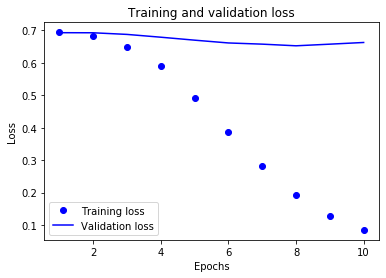

In [19]:
loss = history.history['loss']         # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')      # bo -> 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b -> 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

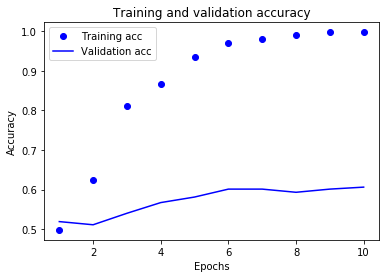

In [20]:
# 그래프 초기화
plt.clf()

acc = history.history['acc']           # 훈련 정확도
val_acc = history.history['val_acc']   # 검증 정확도

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
result = model.evaluate(x_test, y_te)
result

32/32 [==============================] - 0s 1ms/step - loss: 0.6645 - acc: 0.6120


[0.6644690036773682, 0.6119999885559082]

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            500000    
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                24016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 524,305
Trainable params: 524,305
Non-trainable params: 0
_________________________________________________________________
